<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/correlation/folder/Stacking_classification_with_trend_following_class_labels(Working).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification (with class labels)
***

# Import

In [1]:
!pip install vecstack
!pip install yfinance --upgrade --no-cache-dir

  Created wheel for vecstack: filename=vecstack-0.4.0-py3-none-any.whl size=19878 sha256=d9813549caed4b8414ddde45bae36874940a9994d6ad34be993d5286518561fd
  Stored in directory: /root/.cache/pip/wheels/28/fe/0c/fe8e43660e3316d7ce204e59a79a72246c0ae9b6c5c79841c8
Successfully built vecstack
     |████████████████████████████████| 6.3 MB 6.6 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=6c3d332c9664ad28f562a3472c9858e1868a4c3c5e33e8dcc01d019ceb82b4e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-_f2sv6ia/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
!pip install pandas-ta==0.2.45b

     |████████████████████████████████| 88 kB 3.2 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.2.45b0-py3-none-any.whl size=175303 sha256=a96cd6969647036fdf3d27f945b7141cd12f5b7573112a7c578f0159920b7c60
  Stored in directory: /root/.cache/pip/wheels/b1/49/60/e674e28ae57160651c6198b76e1714a0b175e44e022fcd5137
Successfully built pandas-ta


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from vecstack import stacking
import yfinance as yf
import numpy as np
import pandas as pd
import pandas_ta as ta
from pandas_datareader import data as pdr
START = "2015-01-01"  #yyyy-mm-dd
END = '2018-05-01'

In [4]:
trend_decider ='percentchange' #'percentchange' #'impulse' # 'sma'#'long' # percentchange
period=1
days_out=14

# Prepare data

In [5]:
tker = '^nsei' #'^nsei'
nifty =yf.download(tker,start=START,end=END)
#nifty=quandl.get('BSE/BOM500112',start_date=START,end_date=END,authtoken='1Mz3xLNFNdUpKENCkArB')
#nifty = pdr.get_data_yahoo(tker, start=START, end=END)
nifty=nifty.dropna()
nifty=nifty.iloc[:,:4]
#del nifty['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [6]:
nifty.columns

Index(['Open', 'High', 'Low', 'Close'], dtype='object')

In [7]:
# Calculate 30 Day Moving Average, Std Deviation, Upper Band and Lower Band

nifty['30 Day MA'] = nifty['Close'].rolling(window=20).mean()

# set .std(ddof=0) for population std instead of sample
nifty['30 Day STD'] = nifty['Close'].rolling(window=20).std() 
nifty['Upper Band'] = nifty['30 Day MA'] + (nifty['30 Day STD'] *1.5)
nifty['Lower Band'] = nifty['30 Day MA'] - (nifty['30 Day STD'] *1.5)
nifty['ADV_26'] = nifty['Close'].rolling(window=26).mean()
nifty['ADV_13'] = nifty['Close'].rolling(window=13).mean()
nifty['ADV_50'] = nifty['Close'].rolling(window=50).mean()
nifty.ta.macd(append=True)
nifty.ta.vortex(append=True)
#nifty.ta.obv(append=True)
print()

In [8]:
df_old = nifty.copy()
# I Just need the Close
price_data = df_old.copy()

In [9]:
features = ['30 Day MA','30 Day STD','Upper Band',\
           'Lower Band','ADV_26','ADV_13','ADV_50','MACD_12_26_9',\
          'MACDh_12_26_9', 'MACDs_12_26_9','VTXP_14', 'VTXM_14', 'open', 'high', 'low', 'close']

In [10]:
price_data.columns

Index(['open', 'high', 'low', 'close', '30 Day MA', '30 Day STD', 'Upper Band',
       'Lower Band', 'ADV_26', 'ADV_13', 'ADV_50', 'MACD_12_26_9',
       'MACDh_12_26_9', 'MACDs_12_26_9', 'VTXP_14', 'VTXM_14'],
      dtype='object')

#####df = df.assign(flag=df['apm'].gt(df['apm'].shift()))

In [11]:
if trend_decider=='impulse':
  price_data=price_data.assign(Flag=(price_data['MACDh_12_26_9'].lt(price_data['MACDh_12_26_9'].shift()) & price_data['ADV_13'].lt(price_data['ADV_13'].shift())))
elif trend_decider=='sma':
  price_data= price_data.assign(Flag=price_data['ADV_50'].lt(price_data['ADV_50'].shift()))
elif trend_decider=='long':
  price_data= price_data.assign(Flag=price_data['ADV_50'].lt(price_data['ADV_50'].shift(period))) 
elif trend_decider=='percentchange':
  close_groups = price_data['close'].transform(lambda x : np.sign(x.diff(days_out)))
  price_data['Flag'] = close_groups  
  price_data=price_data.dropna()

In [12]:
price_data=price_data.assign(Strength_Flag=(price_data['MACDh_12_26_9'].gt(price_data['MACDh_12_26_9'].shift()) & price_data['ADV_13'].lt(price_data['ADV_13'].shift()) | (price_data['MACDh_12_26_9'].lt(price_data['MACDh_12_26_9'].shift()) & price_data['ADV_13'].gt(price_data['ADV_13'].shift()))))

In [13]:
price_data.dropna(inplace=True)

In [14]:
price_data.Strength_Flag.value_counts()

False    392
True     375
Name: Strength_Flag, dtype: int64

In [15]:
price_data.Strength_Flag = price_data.Strength_Flag.replace({True:100, False:5})

In [16]:
X_Cols = price_data[features]
Y_Cols = price_data['Flag']
samp_train= int(len(price_data)*.75) -100
samp_test= samp_train+100
X_train = X_Cols[:samp_train]
X_test = X_Cols[samp_test:]
y_train = Y_Cols[:samp_train]
y_test = Y_Cols[samp_test:]

# Initialize 1st level models

In [17]:
sample_w=price_data[:samp_train].Strength_Flag.values

In [18]:
models_L1 = [
    LogisticRegression(max_iter=800),   
    svm.SVC(kernel='linear'),
    KNeighborsClassifier(),
          
    ExtraTreesClassifier(random_state=0, n_jobs=-1,
                         n_estimators=100, max_depth=3,class_weight='balanced' ),
        
    RandomForestClassifier(n_estimators = 200,max_depth=80,min_samples_leaf=2,max_features='auto',\
                           min_samples_split=2, criterion = "gini", bootstrap=True,random_state = 42),
          
]

In [19]:
'''XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1,sample_weight=sample_w,
                  n_estimators=100, max_depth=3)'''

'XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1,sample_weight=sample_w,\n                  n_estimators=100, max_depth=3)'

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)
model_L1_0 = models_L1[0]
_ = model_L1_0.fit(X_train_sc, y_train)
# save model in file if you need

model_L1_1 = models_L1[1]
_ = model_L1_1.fit(X_train_sc, y_train,sample_weight=sample_w)
# save model in file if you need

model_L1_2 = models_L1[2]
_ = model_L1_2.fit(X_train, y_train)
# save model in file if you need

model_L1_3 = models_L1[3]
_ = model_L1_3.fit(X_train, y_train,sample_weight=sample_w)
# save model in file if you need

model_L1_4 = models_L1[4]
_ = model_L1_4.fit(X_train, y_train,sample_weight=sample_w)


In [22]:
y_pred=model_L1_4.predict(X_test)

In [23]:
# Print the Accuracy of our Model.
print('Correct Prediction RForest (%): ', accuracy_score(y_test, y_pred, normalize = True) * 100.0)

Correct Prediction RForest (%):  95.3125


In [24]:
feature_imp = pd.Series(model_L1_4.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp*100


VTXP_14          31.282472
VTXM_14          26.012149
MACD_12_26_9     11.845460
MACDh_12_26_9     9.971380
MACDs_12_26_9     6.952532
30 Day STD        2.354739
ADV_50            1.716958
low               1.506240
high              1.503211
ADV_26            1.178355
close             1.158226
open              1.024557
Upper Band        1.008457
ADV_13            0.913541
30 Day MA         0.904129
Lower Band        0.667594
dtype: float64

# Perform stacking

In [25]:
S_train, S_test = stacking(models_L1,                     # list of models
                           X_train, y_train, X_test,   # data
                           regression=False,           # classification task (if you need 
                                                       #     regression - set to True)
                           mode='oof',                 # mode: oof for train set, predict test 
                                                       #mode='oof_pred_bag'(for training) and oof for inference
                                                      #     set in each fold and vote
                           needs_proba=False,          # predict class labels (if you need 
                                                       #     probabilities - set to True) 
                           save_dir=None,              # do not save result and log (to save 
                                                       #     in current dir - set to '.')
                           metric=accuracy_score,      # metric: callable
                           n_folds=4,                  # number of folds
                           stratified=True,            # stratified split for folds
                           shuffle=False,               # shuffle the data
                           random_state=0,             # ensure reproducibility
                           verbose=2)                  # print all info

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof]
n_models:     [5]

model  0:     [LogisticRegression]
    fold  0:  [0.85714286]


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  1:  [0.94117647]
    fold  2:  [0.86554622]
    fold  3:  [0.85593220]
    ----
    MEAN:     [0.87994944] + [0.03554283]
    FULL:     [0.88000000]

model  1:     [SVC]
    fold  0:  [0.86554622]
    fold  1:  [0.90756303]
    fold  2:  [0.87394958]
    fold  3:  [0.86440678]
    ----
    MEAN:     [0.87786640] + [0.01753696]
    FULL:     [0.87789474]

model  2:     [KNeighborsClassifier]
    fold  0:  [0.73949580]
    fold  1:  [0.50420168]
    fold  2:  [0.52941176]
    fold  3:  [0.71186441]
    ----
    MEAN:     [0.62124341] + [0.10527062]
    FULL:     [0.62105263]

model  3:     [ExtraTreesClassifier]
    fold  0:  [0.82352941]
    fold  1:  [0.80672269]
    fold  2:  [0.70588235]
    fold  3:  [0.90677966]
    ----
    MEAN:     [0.81072853] + [0.07141157]
    FULL:     [0.81052632]

model  4:     [RandomForestClassifier]
    fold  0:  [0.89075630]
    fold  1:  [0.93277311]
    fold  2:  [0.89915966]
    fold  3:  [0.94067797]
    ----
    MEAN:     [0.91584176] + 

# Look at the result

So now we have OOF from 1st level models and we can build 2nd level model.  
But first let's look at the result.  
We have three 1st level models, so we expect to get three columns in `S_train` and `S_test`.  

In [26]:
S_train[:5]

array([[-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]])

# Apply 2nd level model

In [27]:
# Initialize 2nd level model
model_L2 = XGBClassifier(learning_rate =0.1,
 n_estimators=200,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
    
# Fit 2nd level model
_ = model_L2.fit(S_train, y_train)
# Predict
#y_pred = model_L2.predict(S_test)

# Final prediction score
#print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

In [28]:
# UNDER PRODUCTION
def data_meta(id, x, y, dummy):
  #get prediction from model 1
  #pred_prob_meta = model.predict_proba(x)[:,1]
  pred_prob_meta = pd.Series(dummy, \
  index=x.index,
  name=f'pred_{id}_meta')
  pred_int_meta = pred_prob_meta > Threshold
  y_meta = pd.Series(y & pred_int_meta, name=f'y_train_meta_{id}')
  x_meta = x.join(pred_int_meta)
  return x_meta, y_meta

# Make Predictions

In [29]:
START='2019-01-01'

In [30]:
nifty_test=yf.download(tker,start=START) #end='2020-07-04'

[*********************100%***********************]  1 of 1 completed


In [31]:
#nifty_test = pdr.get_data_yahoo(tker, start=START)
nifty_test=nifty_test.dropna()
del nifty_test['Adj Close']

In [32]:
# Calculate 30 Day Moving Average, Std Deviation, Upper Band and Lower Band

nifty_test['30 Day MA'] = nifty_test['Close'].rolling(window=20).mean()

# set .std(ddof=0) for population std instead of sample
nifty_test['30 Day STD'] = nifty_test['Close'].rolling(window=20).std() 

nifty_test['Upper Band'] = nifty_test['30 Day MA'] + (nifty_test['30 Day STD'] *1.5)
nifty_test['Lower Band'] = nifty_test['30 Day MA'] - (nifty_test['30 Day STD'] *1.5)
nifty_test['ADV_26'] = nifty_test['Close'].rolling(window=26).mean()
nifty_test['ADV_13'] = nifty_test['Close'].rolling(window=13).mean()
nifty_test['ADV_50'] = nifty_test['Close'].rolling(window=50).mean()
nifty_test.ta.macd(append=True)
nifty_test.ta.vortex(append=True)
nifty_test.ta.obv(append=True)

df = nifty_test.copy()
# I Just need the Close
price_data_new = df.copy()

price_data_new.head(2)

,open,high,low,close,volume,30 Day MA,30 Day STD,Upper Band,Lower Band,ADV_26,ADV_13,ADV_50,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,VTXP_14,VTXM_14,OBV
date,,,,,,,,,,,,,,,,,,
2019-01-02,10868.849609,10895.349609,10735.049805,10792.50,309700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,309700.0
2019-01-03,10796.799805,10814.049805,10661.250000,10672.25,286200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23500.0


In [33]:
# Group by the `Symbol` column, then grab the `Close` column.
#close_groups = price_data_new['Close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
#close_groups = close_groups.transform(lambda x : np.sign(x.diff(days_out)))

# add the data to the main dataframe.
#price_data_new['Prediction'] = close_groups
price_data_new = price_data_new.dropna()

X_Cols = price_data_new[features]
#Y_Cols = price_data_new['Prediction']

X_test_new = X_Cols


In [34]:
#[4] Then new test set (X_test_new) comes. We load our 1st level models and predict new test set to get stacked features (S_test_new):

y_pred_L1_0 = model_L1_0.predict(sc.fit_transform(X_test_new))
y_pred_L1_1 = model_L1_1.predict(sc.fit_transform(X_test_new))
y_pred_L1_2 = model_L1_2.predict(X_test_new)
y_pred_L1_3 = model_L1_3.predict(X_test_new)
y_pred_L1_4 = model_L1_4.predict(X_test_new)
S_test_new = np.c_[y_pred_L1_0, y_pred_L1_1,y_pred_L1_2,y_pred_L1_3,y_pred_L1_4]
#[5] Then we load our 2nd level model and predict S_test_new to get final prediction:

y_pred_new = model_L2.predict(S_test_new)

In [35]:
y_pred_new_p = model_L2.predict_proba(S_test_new) #checks probability

In [36]:
y_pred_new_p=max(y_pred_new_p[-1].tolist())*100
print(f'The Probability of the confident class is {round(y_pred_new_p,3)}% ')

The Probability of the confident class is 95.846% 


In [37]:
if trend_decider=='impulse':
  price_data_new=price_data_new.assign(Flag=(price_data_new['MACDh_12_26_9'].lt(price_data_new['MACDh_12_26_9'].shift(1)) & price_data_new['ADV_13'].lt(price_data_new['ADV_13'].shift(1))))
elif trend_decider=='sma':  
  price_data_new= price_data_new.assign(Flag=price_data_new['ADV_50'].lt(price_data_new['ADV_50'].shift()))
elif trend_decider=='long':
  price_data_new= price_data_new.assign(Flag=price_data_new['ADV_50'].lt(price_data_new['ADV_50'].shift(period)))
elif trend_decider=='percentchange':
  close_groups = price_data_new['close'].transform(lambda x : np.sign(x.diff(days_out)))
  price_data_new['Flag'] = close_groups
  price_data_new=price_data_new.fillna(0)

In [38]:
price_data_new=price_data_new.assign(Strength_Flag=(price_data_new['MACDh_12_26_9'].gt(price_data_new['MACDh_12_26_9'].shift()) & price_data_new['ADV_13'].lt(price_data_new['ADV_13'].shift()) | (price_data_new['MACDh_12_26_9'].lt(price_data_new['MACDh_12_26_9'].shift()) & price_data_new['ADV_13'].gt(price_data_new['ADV_13'].shift()))))

In [39]:
price_data_new.Strength_Flag = price_data_new.Strength_Flag.replace({True: 20, False: 1})

In [40]:
price_data_new.shape

(617, 20)

In [41]:
if trend_decider !='percentchange':
  price_data_new.Flag = price_data_new.Flag.replace({True: 0, False: 1})
  y_pred_new=y_pred_new.astype(int)
  indices_one = y_pred_new == 1
  indices_zero = y_pred_new == 0
  y_pred_new[indices_one] = 0 # replacing 1s with 0s
  y_pred_new[indices_zero] = 1 # replacing 0s with 1s
if trend_decider =='percentchange':
  price_data_new.Flag = price_data_new.Flag.replace({0.0: 1.0})
  print('done')

done


In [42]:
actuals=price_data_new['Flag']
len(actuals)

617

In [43]:
len(actuals)

617

In [44]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(price_data_new['Flag'], y_pred_new)

In [45]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(price_data_new.Flag.shift(-1)[:-1], y_pred_new[:-1])

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

In [46]:
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
f1score= 2*recall*percision/(percision+recall)
print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {}'.format(float(f1score)))
print('Average Precision : {}'.format(float(average_precision)))

Accuracy: 0.8522727272727273
Percision: 0.8847058823529412
Recall: 0.8995215311004785
Specificity: 0.7525252525252525
F1-Score: 0.8920521945432978
Average Precision : 0.9243272440466653


In [47]:
if trend_decider != 'percentchange':
  buy= np.where(y_pred_new==1.0)
  #sell= np.where(y_pred_new==-1.0)[0].tolist()
  b_a=np.where(price_data_new.Flag.values==1)
  #s_a=np.where(price_data_new.Flag.values==-1)
else:
  buy= np.where(y_pred_new==1)
  sell= np.where(y_pred_new==0)
  b_a=np.where(price_data_new.Flag.values==1)
  s_a=np.where(price_data_new.Flag.values==0)

In [48]:
#if trend_decider != 'percentchange':
sell= np.where(y_pred_new==-1.0)[0].tolist()
#s_a=np.where(price_data_new.Flag.values==-1)

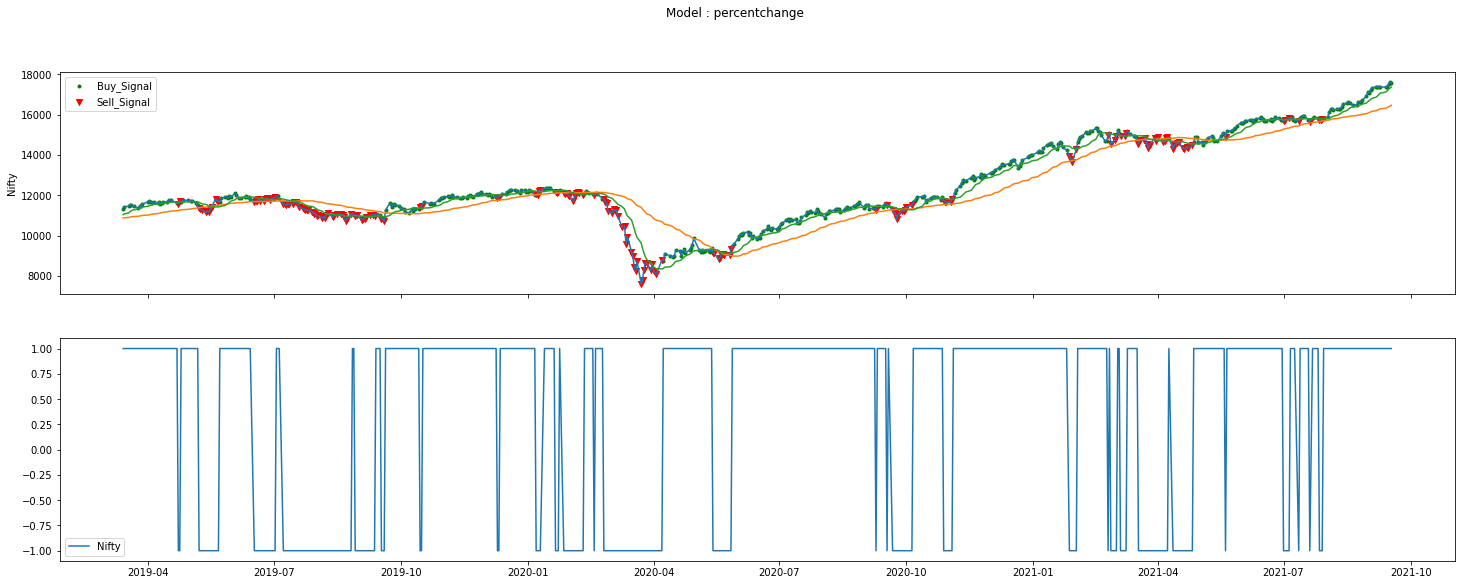

In [53]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1, figsize=(25,9),sharex=True)
ax[0].plot(price_data_new.loc[:, :].index, price_data_new.loc[:, 'close'])
ax[1].plot(price_data_new.loc[:, :].index, y_pred_new, label='Nifty')
ax[0].scatter(price_data_new.iloc[buy].index,price_data_new.iloc[buy].close,marker='.',label='Buy_Signal',color='g')
ax[0].scatter(price_data_new.iloc[sell].index,price_data_new.iloc[sell].close,marker='v',label='Sell_Signal',color='r')
ax[0].plot(price_data_new['ADV_50'])
ax[0].plot(price_data_new['ADV_13'])
#ax[2].plot(price_data_new.loc[:, :].index, price_data_new.loc[:, 'close'])
#ax[2].scatter(price_data_new.iloc[b_a].index,price_data_new.iloc[b_a].close,marker='.',label='Buy_ML_Signal',color='g')
#ax[2].scatter(price_data_new.iloc[s_a].index,price_data_new.iloc[s_a].close,marker='v',label='Sell_ML_Signal',color='r')
ax[0].legend()

ax[0].set_ylabel('Nifty')

ax[1].legend(loc='best')

#ax[2].legend(loc='upper left')
if trend_decider!='percentchange':
  fig.suptitle('Model : '+ trend_decider +' with period :' + str(period))
else:
  fig.suptitle('Model : '+ trend_decider )  

plt.show()


In [50]:
print(f'The Probability of the confident class is {round(y_pred_new_p,3)}%')

The Probability of the confident class is 95.846%
